Exploratory Data Analysis - Credit Card Fraud Detection
=======================================================
Objective: Understand the data characteristics and fraud patterns.

In [3]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')
import os
os.chdir('..')

from src.data.loader import DataLoader

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Imports sucessful")

Imports sucessful


In [4]:
# Load Data
loader = DataLoader()
df = loader.load_data()

info = loader.get_basic_info(df)

print("=" * 50)
print("📊 DATASET OVERVIEW")
print("=" * 50)
for key, value in info.items():
    print(f"{key:20s}: {value}")

2025-09-28 16:50:51,279 - INFO - Loading data from data\raw\creditcard.csv
2025-09-28 16:50:52,248 - INFO - Data validation passed!
2025-09-28 16:50:52,251 - INFO - Loaded 284,807 transactions
2025-09-28 16:50:52,252 - INFO - Fraud rate: 0.17%
2025-09-28 16:50:52,255 - INFO - Memory usage: 67.4 MB


📊 DATASET OVERVIEW
n_transactions      : 284807
n_features          : 30
fraud_rate          : 0.17%
n_frauds            : 492
n_normal            : 284315
imbalance_ratio     : 577.9:1
memory_mb           : 67.4
time_span_hours     : 48.0


In [5]:
# Data Quality Check
print("=" * 50)
print("🔍 DATA QUALITY ASSESSMENT")
print("=" * 50)

# Check for missing values
missing = df.isnull().sum().sum()
print(f"Missing values: {missing}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Check data types
print(f"All numeric: {df.select_dtypes(include=[np.number]).shape[1] == df.shape[1]}")

# Check value ranges for target
print(f"\nTarget Variable:")
print(df['Class'].value_counts())
print(f"\nFraud Rate: {df['Class'].mean():.4f} ({df['Class'].mean()*100:.2f}%)")

🔍 DATA QUALITY ASSESSMENT
Missing values: 0
Duplicate rows: 1081
All numeric: True

Target Variable:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud Rate: 0.0017 (0.17%)


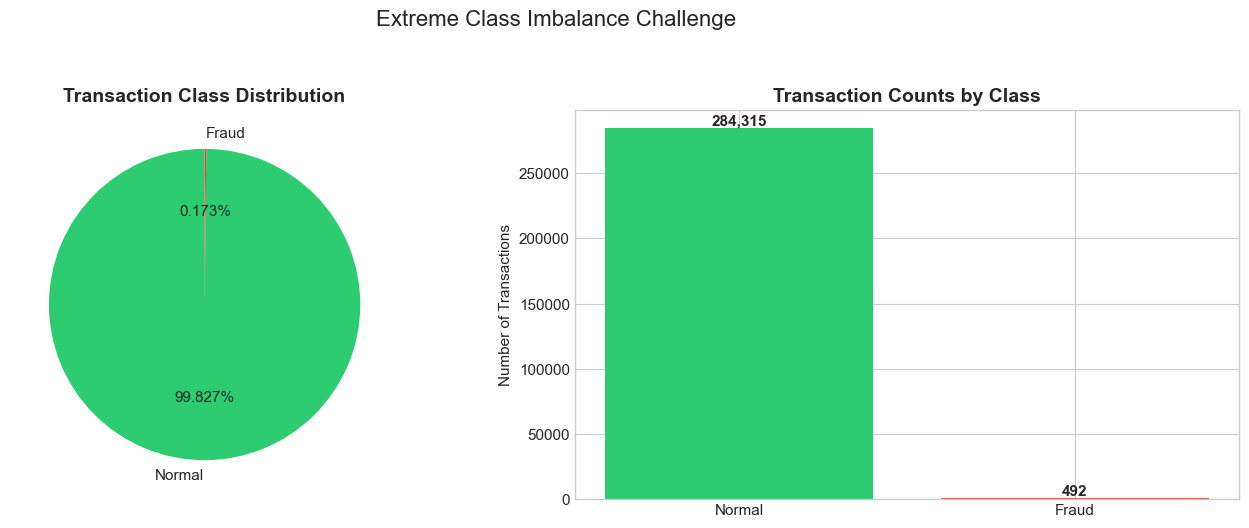

In [6]:
# Class Distribution Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
ax1 = axes[0]
class_counts = df['Class'].value_counts()
colors = ['#2ecc71', '#e74c3c']
ax1.pie(class_counts.values, labels=['Normal', 'Fraud'], 
        autopct='%1.3f%%', colors=colors, startangle=90)
ax1.set_title('Transaction Class Distribution', fontsize=14, fontweight='bold')

# Bar chart with counts
ax2 = axes[1]
bars = ax2.bar(['Normal', 'Fraud'], class_counts.values, color=colors)
ax2.set_ylabel('Number of Transactions')
ax2.set_title('Transaction Counts by Class', fontsize=14, fontweight='bold')

# Value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Extreme Class Imbalance Challenge', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

<small>Insight: With only 0.17% fraud rate, we have a severe imbalance problem \
Ratio: 577.9 normal transactions for every 1 fraud</small>

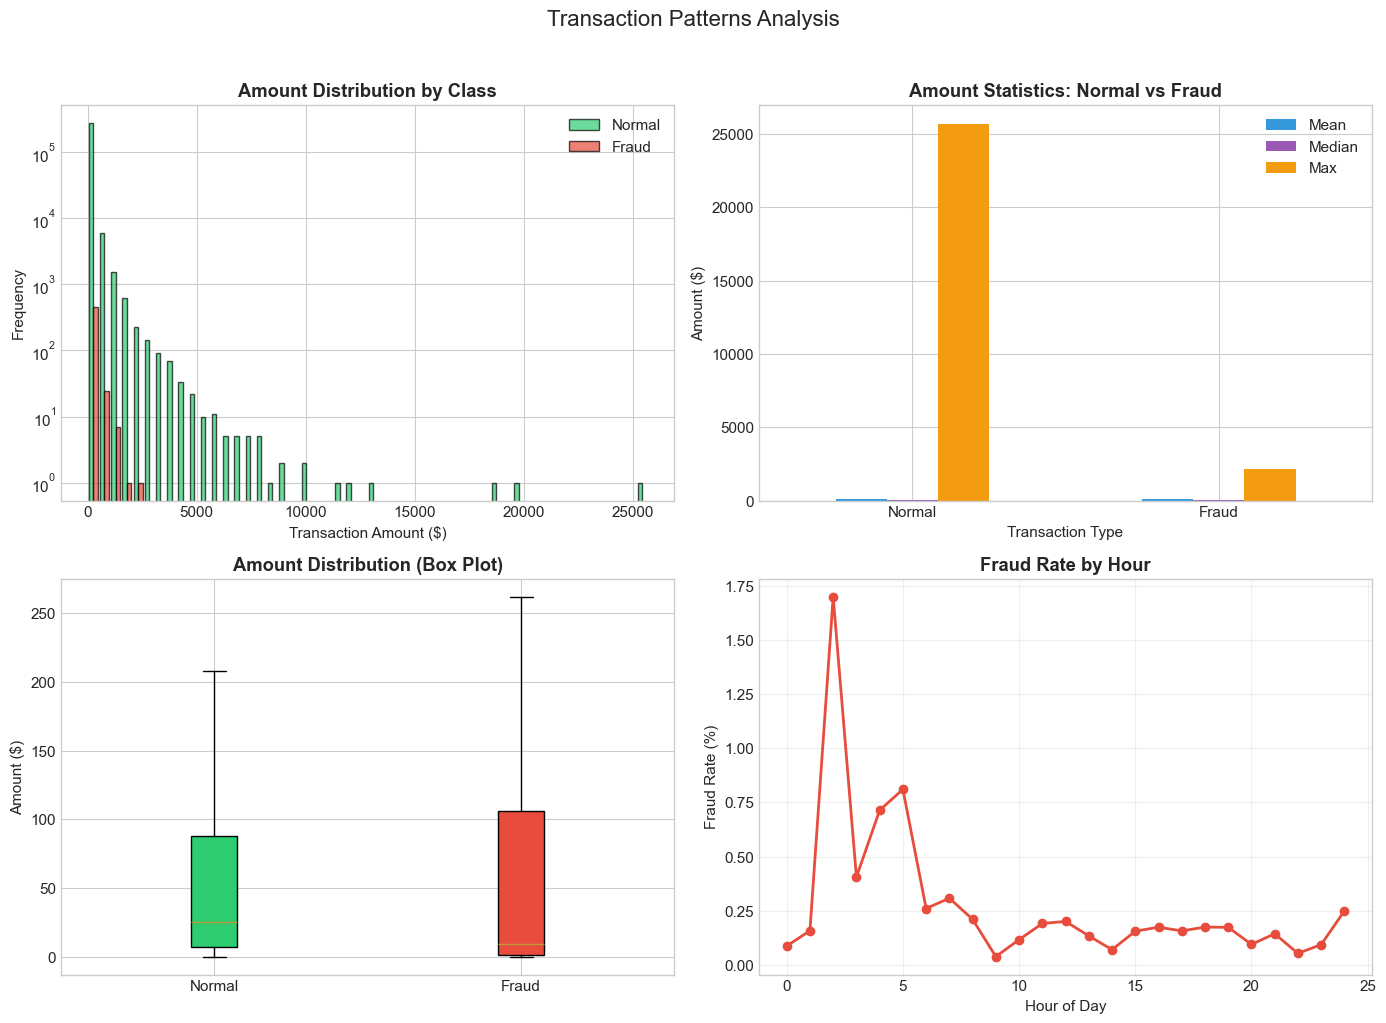

Key Amount Statistics:
Normal transactions: Mean=$88.29, Median=$22.00
Fraud transactions:  Mean=$122.21, Median=$9.25

Insight: Fraudulent transactions tend to have lower amounts!
Median fraud ($9.25) < Median normal ($22.00)


In [7]:
# Transaction Amount Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Amount distribution by class
ax1 = axes[0, 0]
normal_amounts = df[df['Class'] == 0]['Amount']
fraud_amounts = df[df['Class'] == 1]['Amount']

ax1.hist([normal_amounts, fraud_amounts], bins=50, 
         label=['Normal', 'Fraud'], color=['#2ecc71', '#e74c3c'],
         alpha=0.7, edgecolor='black')
ax1.set_xlabel('Transaction Amount ($)')
ax1.set_ylabel('Frequency')
ax1.set_title('Amount Distribution by Class', fontweight='bold')
ax1.set_yscale('log')  # Log scale to see both classes
ax1.legend()

# Statistical comparison
ax2 = axes[0, 1]
amount_stats = pd.DataFrame({
    'Normal': normal_amounts.describe(),
    'Fraud': fraud_amounts.describe()
}).T[['mean', '50%', 'max']]  # 50% is median

amount_stats.plot(kind='bar', ax=ax2, color=['#3498db', '#9b59b6', '#f39c12'])
ax2.set_title('Amount Statistics: Normal vs Fraud', fontweight='bold')
ax2.set_xlabel('Transaction Type')
ax2.set_ylabel('Amount ($)')
ax2.set_xticklabels(['Normal', 'Fraud'], rotation=0)
ax2.legend(['Mean', 'Median', 'Max'])

# Box plot comparison (better for outliers)
ax3 = axes[1, 0]
plot_data = pd.DataFrame({
    'Normal': normal_amounts.sample(1000),  # Sample for visibility
    'Fraud': fraud_amounts
})
box = ax3.boxplot([normal_amounts.sample(1000), fraud_amounts], 
                   labels=['Normal', 'Fraud'],
                   patch_artist=True, showfliers=False)
box['boxes'][0].set_facecolor('#2ecc71')
box['boxes'][1].set_facecolor('#e74c3c')
ax3.set_ylabel('Amount ($)')
ax3.set_title('Amount Distribution (Box Plot)', fontweight='bold')

# Time patterns
ax4 = axes[1, 1]
# Time is seconds from start of dataset
df['Hour'] = (df['Time'] / 3600) % 24
hourly_fraud_rate = df.groupby(df['Hour'].round())['Class'].mean() * 100

ax4.plot(hourly_fraud_rate.index, hourly_fraud_rate.values, 
         marker='o', color='#e74c3c', linewidth=2)
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Fraud Rate (%)')
ax4.set_title('Fraud Rate by Hour', fontweight='bold')
ax4.grid(True, alpha=0.3)
df = df.drop('Hour', axis=1)

plt.suptitle('Transaction Patterns Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Key statistics
print("Key Amount Statistics:")
print(f"Normal transactions: Mean=${normal_amounts.mean():.2f}, Median=${normal_amounts.median():.2f}")
print(f"Fraud transactions:  Mean=${fraud_amounts.mean():.2f}, Median=${fraud_amounts.median():.2f}")
print(f"\nInsight: Fraudulent transactions tend to have lower amounts!")
print(f"Median fraud (${fraud_amounts.median():.2f}) < Median normal (${normal_amounts.median():.2f})")

In [8]:
# Accuracy Fails
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Simulate a "dumb" model that predicts everything as normal
y_true = df['Class'].values
y_pred_all_normal = np.zeros_like(y_true)  # Predict everything as 0 (normal)

# Calculate metrics
accuracy = (y_pred_all_normal == y_true).mean()
fraud_caught = ((y_pred_all_normal == 1) & (y_true == 1)).sum()
total_frauds = (y_true).sum()

print("=" * 50)
print(f"If we predict EVERYTHING as normal (no fraud):")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Frauds caught: {fraud_caught} out of {total_frauds} (0%)")
print(f"Business impact: ALL fraud goes undetected! 💸")
print("ACCURACY IS MISLEADING")
print("=" * 50)

If we predict EVERYTHING as normal (no fraud):
Accuracy: 0.9983 (99.83%)
Frauds caught: 0 out of 492 (0%)
Business impact: ALL fraud goes undetected! 💸
ACCURACY IS MISLEADING


Better Metrics for Imbalanced Data:
<small>
<li>Precision: Of predicted frauds, how many are real? Reduced false alarms.</li>
<li>Recall: Of actual frauds, how many did we catch? Reduces fraud losses.</li>
<li>F1 Score: Balance between precision and recall.</li>
<li>AUC-PR: Area under Precision-Recall curve.</li>
</small>
<br>
For Fraud Detection, we want:
<small>
<li>High recall and Reasonable precision</li>
</small>

In [9]:
# Finding Important Features
from sklearn.ensemble import RandomForestClassifier

feature_cols = [col for col in df.columns if col not in ['Class', 'Time']]
X = df[feature_cols]
y = df['Class']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Number of features we'll analyze: {len(feature_cols)} features")

X shape: (284807, 29)
y shape: (284807,)
Number of features we'll analyze: 29 features


In [10]:
# Train Random Forest for Feature Importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Train on a sample
X_sample, _, y_sample, _ = train_test_split(
    X, y,
    train_size=10000,
    stratify=y,
    random_state=42
)

print(f"Training on {len(X_sample)} samples...")
print(f"Fraud rate in sample: {y_sample.mean():.4f}")
print(f"Number of fraud cases: {y_sample.sum()}")
print(f"Number of normal cases: {len(y_sample) - y_sample.sum()}")

# Create a Random Forest
rf = RandomForestClassifier(
    n_estimators=50,        # Use 50 trees (less = faster)
    max_depth=10,           # Don't let trees get too deep
    random_state=42,        # For reproducibility
    n_jobs=-1,              # Use all CPU cores
    class_weight='balanced' # Handle imbalance!
)

# Train the model
rf.fit(X_sample, y_sample)

print("Training complete!")

Training on 10000 samples...
Fraud rate in sample: 0.0017
Number of fraud cases: 17
Number of normal cases: 9983
Training complete!


In [11]:
# Extract Feature Importance
import pandas as pd

# Get importance scores from the trained model
importance_scores = rf.feature_importances_

# Create a DataFrame for easy analysis
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance_scores
})

# Sort by importance
importance_df = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Display top 10
print("TOP 10 MOST IMPORTANT FEATURES:")
print("=" * 50)
for idx, row in importance_df.head(10).iterrows():
    print(f"{row['feature']:8s}: {row['importance']:.4f}")
    
print(f"\nAmount rank: #{importance_df[importance_df['feature'] == 'Amount'].index[0] + 1}")

TOP 10 MOST IMPORTANT FEATURES:
V10     : 0.2233
V14     : 0.1271
V16     : 0.1133
V17     : 0.0983
V11     : 0.0966
V12     : 0.0782
V4      : 0.0521
V3      : 0.0368
V7      : 0.0323
V18     : 0.0256

Amount rank: #13


Amount Analysis:
Rank: #13 out of 29
Importance: 0.0135


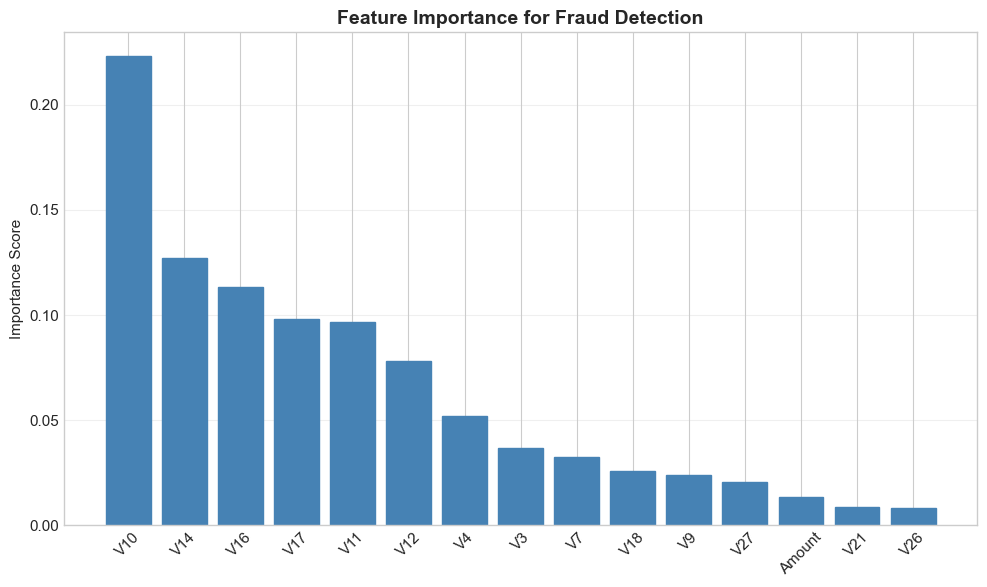

Insight: The PCA features are much more important than Amount!
This suggests original features had strong fraud patterns.


In [12]:
# Check Amounts importance and visualize top features
import matplotlib.pyplot as plt

# Find Amount's rank
amount_rank = importance_df[importance_df['feature']=='Amount'].index[0] + 1
amount_importance = importance_df[importance_df['feature']=='Amount']['importance'].values[0]

print(f"Amount Analysis:")
print(f"Rank: #{amount_rank} out of {len(importance_df)}")
print(f"Importance: {amount_importance:.4f}")

# Simple bar chart
fig, ax = plt.subplots(figsize=(10,6))

# Plot top 15 features
top_15 = importance_df.head(15)
bars = ax.bar(range(len(top_15)), top_15['importance'].values)
for bar in bars:
    bar.set_color('steelblue')

ax.set_xticks(range(len(top_15)))
ax.set_xticklabels(top_15['feature'].values, rotation=45)
ax.set_ylabel("Importance Score")
ax.set_title('Feature Importance for Fraud Detection', fontweight='bold', fontsize=14)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Insight: The PCA features are much more important than Amount!")
print("This suggests original features had strong fraud patterns.")

Analyzing top 4 features: V10, V14, V16, V17


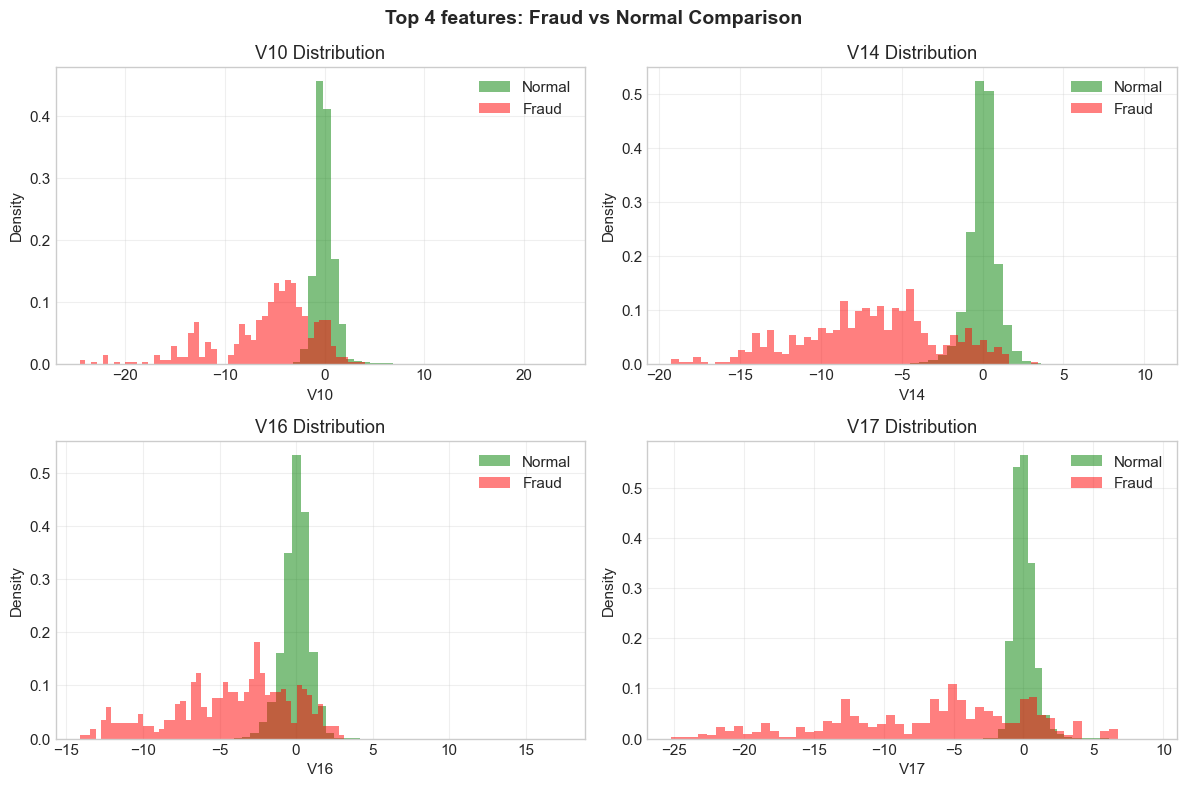

Look for seperation between red (fraud) and green(normal)!
More seperation = better at detecting fraud


In [13]:
# Compare Top Feature (V10) Between Fraud and Normal
top_4_features = importance_df.head(4)['feature'].values
print(f"Analyzing top 4 features: {', '.join(top_4_features)}")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel() # Flatten 2x2 grid to simple array

for idx, feature in enumerate(top_4_features):
    ax =axes[idx]
    
    # Get data for this feature
    normal_vals = df[df['Class'] == 0][feature]
    fraud_vals = df[df['Class'] == 1][feature]
    
    # Plot histograms
    ax.hist(normal_vals, bins=50, alpha=0.5, label='Normal',
            color='green', density=True)
    ax.hist(fraud_vals, bins=50, alpha=0.5, label='Fraud',
            color='red', density=True)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title(f'{feature} Distribution')
    ax.legend()
    ax.grid(alpha=0.3)
    
plt.suptitle('Top 4 features: Fraud vs Normal Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Look for seperation between red (fraud) and green(normal)!")
print("More seperation = better at detecting fraud")

In [14]:
# Statistical Comparison of Top Features
import pandas as pd

stats_comparison = []

for feature in top_4_features:
    normal_vals = df[df['Class'] == 0][feature]
    fraud_vals = df[df['Class'] == 1][feature]
    
    stats_comparison.append({
        'Feature': feature,
        'Normal_Mean': normal_vals.mean(),
        'Fraud_Mean': fraud_vals.mean(),
        'Difference': fraud_vals.mean() - normal_vals.mean(),
        'Normal_Std': normal_vals.std(),
        'Fraud_Std': fraud_vals.std()
    })
    
stats_df = pd.DataFrame(stats_comparison)

print("STATISTICAL COMPARISON:")
print("="*50)
for _, row in stats_df.iterrows():
    print(f"\n{row['Feature']}:")
    print(f"    Normal: mean={row['Normal_Mean']:.2f}, std= {row['Normal_Std']:.2f}")
    print(f"    Fraud: mean={row['Fraud_Mean']:.2f}, std={row['Fraud_Std']:.2f}")
    print(f"    -> Fraud shifts by {row['Difference']:.2f} units")
    
print("\nInsight:")
print("Fraud transactions have NEGATIVE values in these features,")
print("while normal transactions center around ZERO.")
print("This clear seperation is why these features rank so high!")

STATISTICAL COMPARISON:

V10:
    Normal: mean=0.01, std= 1.04
    Fraud: mean=-5.68, std=4.90
    -> Fraud shifts by -5.69 units

V14:
    Normal: mean=0.01, std= 0.90
    Fraud: mean=-6.97, std=4.28
    -> Fraud shifts by -6.98 units

V16:
    Normal: mean=0.01, std= 0.84
    Fraud: mean=-4.14, std=3.87
    -> Fraud shifts by -4.15 units

V17:
    Normal: mean=0.01, std= 0.75
    Fraud: mean=-6.67, std=6.97
    -> Fraud shifts by -6.68 units

Insight:
Fraud transactions have NEGATIVE values in these features,
while normal transactions center around ZERO.
This clear seperation is why these features rank so high!


In [15]:
# EDA Summary and Saving Insights
import json
import os

eda_insights = {
    'data_stats': {
        'total_transactions': len(df),
        'fraud_count': int(df['Class'].sum()),
        'fraud_rate': float(df['Class'].mean()),
        'imbalance_ratio': float(len(df[df['Class']==0]) / len(df[df['Class']==1]))
    },
    'amount_analysis': {
        'normal_median': float(df[df['Class']==0]['Amount'].median()),
        'fraud_median': float(df[df['Class']==1]['Amount'].median()),
        'insight': 'Fraud transactions have lower amounts.'
    },
    'top_features': importance_df.head(10)['feature'].to_list(),
    'feature_importance': {
        row['feature']: float(row['importance'])
        for _, row in importance_df.head(10).iterrows()
    }
}

# Print summary
print("="*50)
print("📋 FINAL EDA SUMMARY")
print("="*60)

print(f"\n1️⃣ CLASS IMBALANCE")
print(f"     Fraud rate: {eda_insights['data_stats']['fraud_rate']:.2%}")
print(f"     Ratio: {eda_insights['data_stats']['imbalance_ratio']:.0f}:1 (normal:fraud)")
print(f"     Action: Use SMOTE, class weights, or focal loss")

print(f"\n2️⃣ AMOUNT PATTERNS")
print(f"     Normal median: ${eda_insights['amount_analysis']['normal_median']:.2f}")
print(f"     Fraud median: ${eda_insights['amount_analysis']['fraud_median']:.2f}")
print(f"     Action: Create amount bins as features.")

print(f"\n3️⃣ TOP 5 FEATURES")
for i, feature in enumerate(eda_insights['top_features'][:5], 1):
    importance = eda_insights['feature_importance'][feature]
    print(f"   {i}. {feature}: {importance:.3f} importance")
print(f"     Action: Focus on these in feature selection")

print(f"\n4️⃣ MODELING STRATEGY")
print(f"   • Metrics: Use Precision-Recall, not accuracy")
print(f"   • Baseline: Logistic Regression with class weights")
print(f"   • Advanced: Random Forest, XGBoost with SMOTE")
print(f"   • Validation: Stratified K-fold to maintain fraud ratio")

# Save to file
os.makedirs('data/processed', exist_ok=True)
with open('data/processed/eda_insights.json', 'w') as f:
    json.dump(eda_insights, f, indent=2)
    
print("\n✅ Insights saved to data/processed/eda_insights.json")

📋 FINAL EDA SUMMARY

1️⃣ CLASS IMBALANCE
     Fraud rate: 0.17%
     Ratio: 578:1 (normal:fraud)
     Action: Use SMOTE, class weights, or focal loss

2️⃣ AMOUNT PATTERNS
     Normal median: $22.00
     Fraud median: $9.25
     Action: Create amount bins as features.

3️⃣ TOP 5 FEATURES
   1. V10: 0.223 importance
   2. V14: 0.127 importance
   3. V16: 0.113 importance
   4. V17: 0.098 importance
   5. V11: 0.097 importance
     Action: Focus on these in feature selection

4️⃣ MODELING STRATEGY
   • Metrics: Use Precision-Recall, not accuracy
   • Baseline: Logistic Regression with class weights
   • Advanced: Random Forest, XGBoost with SMOTE
   • Validation: Stratified K-fold to maintain fraud ratio

✅ Insights saved to data/processed/eda_insights.json


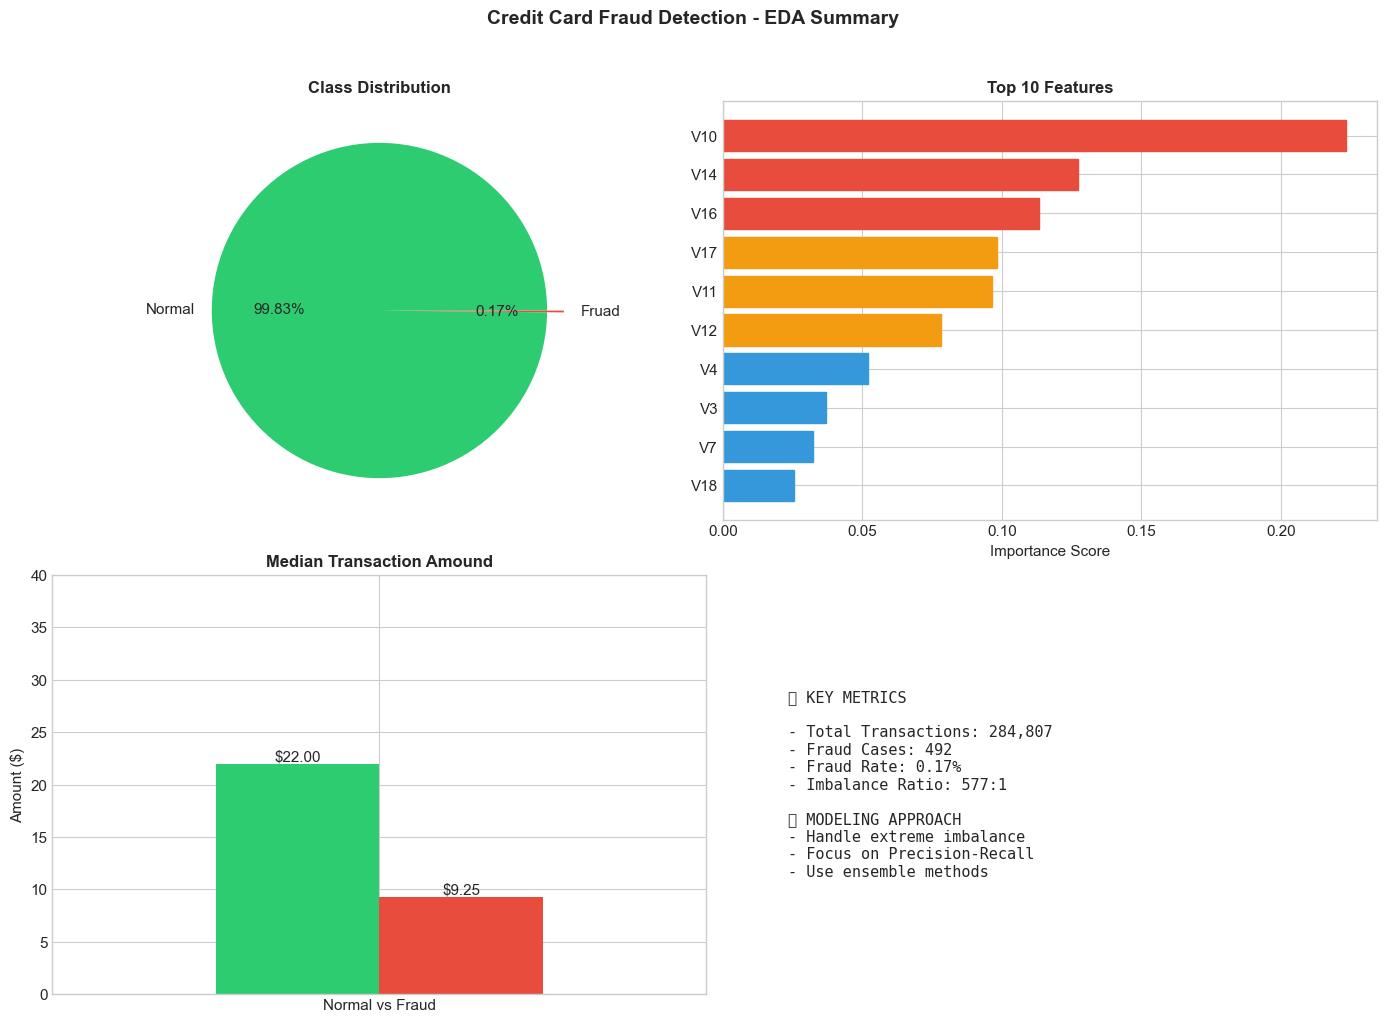

📸 Summary visualization saved to data/processed/eda_summary.png


In [ ]:
# Summary Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Class Distribution
ax1 = axes[0, 0]
class_counts = df['Class'].value_counts()
colors = ['#2ecc71', '#e74c3c']
wedges, texts, autotexts = ax1.pie(class_counts.values,
                                   labels=['Normal', 'Fruad'],
                                   autopct='%1.2f%%',
                                   colors=colors,
                                   explode=[0, 0.1])
ax1.set_title('Class Distribution', fontsize=12, fontweight='bold')

# 2. Top 10 Feature Importance
ax2 = axes[0, 1]
top_10 = importance_df.head(10)
bars = ax2.barh(range(len(top_10)), top_10['importance'].values)
ax2.set_yticks(range(len(top_10)))
ax2.set_yticklabels(top_10['feature'].values)
ax2.set_xlabel('Importance Score')
ax2.set_title('Top 10 Features', fontsize=12, fontweight='bold')
ax2.invert_yaxis()

# Color code by importance level
for i, bar in enumerate(bars):
    if i < 3:
        bar.set_color('#e74c3c') # Top 3 red
    elif i < 6:
        bar.set_color('#f39c12') # Next 3 orange
    else:
        bar.set_color('#3498db') # Rest blue
        
# 3. Amount Distribution
ax3 = axes[1, 0]
amount_stats = pd.DataFrame({
    'Normal': [df[df['Class']==0]['Amount'].median()],
    'Fraud': [df[df['Class']==1]['Amount'].median()]
})
amount_stats.plot(kind='bar', ax=ax3, color=['#2ecc71', '#e74c3c'], legend=False)
ax3.set_title('Median Transaction Amound', fontsize=12, fontweight='bold')
ax3.set_ylabel('Amount ($)')
ax3.set_xticklabels(['Normal vs Fraud'], rotation=0)
ax3.set_ylim(0, 40)

# Add value labels
for container in ax3.containers:
    ax3.bar_label(container, fmt='$%.2f')
    
# 4. Key Metrics
ax4 = axes[1, 1]
ax4.axis('off')
metrics_text = f"""
📊 KEY METRICS

- Total Transactions: {len(df):,}
- Fraud Cases: {df['Class'].sum():,}
- Fraud Rate: {df['Class'].mean():.2%}
- Imbalance Ratio: {int(eda_insights['data_stats']['imbalance_ratio'])}:1

🎯 MODELING APPROACH
- Handle extreme imbalance
- Focus on Precision-Recall
- Use ensemble methods
"""
ax4.text(0.1, 0.5, metrics_text, fontsize=11, verticalalignment='center', fontfamily='monospace')

plt.suptitle('Credit Card Fraud Detection - EDA Summary', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
plt.savefig('data/processed/eda_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print('📸 Summary visualization saved to data/processed/eda_summary.png')